## 1. Environment Setup

In [33]:
import sys
import os
import json
import warnings
from pathlib import Path

# CRITICAL FIX: Prevent OpenMP runtime conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, Markdown

# SEM / CFA
import semopy
from semopy import Model

# Reliability calculations
import pingouin as pg

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

POPULATION = 'academic'
N_BOOTSTRAP = 500  # Bootstrap iterations for small sample

# Ensure output directories exist
Path('plots').mkdir(exist_ok=True)
Path('tables').mkdir(exist_ok=True)

print("✓ Libraries loaded")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Population: {POPULATION.upper()}")
print(f"✓ Bootstrap iterations: {N_BOOTSTRAP}")
print(f"✓ semopy version: {semopy.__version__}")

✓ Libraries loaded
✓ Random seed: 67
✓ Population: ACADEMIC
✓ Bootstrap iterations: 500
✓ semopy version: 2.3.11


## 2. Load Data and ALL EFA Solutions

In [34]:
# Load holdout sample for CFA validation
df_holdout = pd.read_csv('data/AIRS_holdout.csv')

# Load ALL EFA solutions from Phase 1
with open('data/all_efa_solutions.json', 'r') as f:
    all_efa_solutions = json.load(f)

# Load item metadata
with open('../data/airs_28item_complete.json', 'r') as f:
    item_metadata = json.load(f)

metadata = item_metadata['metadata']
predictor_items = item_metadata['predictor_items']

n_holdout = len(df_holdout)

print(f"📊 {POPULATION.upper()} Sample CFA Validation")
print(f"   Holdout N: {n_holdout}")

# Sample size warning
if n_holdout < 100:
    print(f"\n⚠️ SMALL SAMPLE WARNING: N={n_holdout} < 100")
    print(f"   → Bootstrap standard errors will be used")
    print(f"   → Fit indices should be interpreted with caution")

print(f"\nEFA Solutions to Test:")
print(f"   Solutions: {all_efa_solutions['solutions_tested']}")
print(f"   PA recommended: {all_efa_solutions['pa_recommended']}-factor")
print(f"   Kaiser criterion: {all_efa_solutions['kaiser_recommended']}-factor")

📊 ACADEMIC Sample CFA Validation
   Holdout N: 59

⚠️ SMALL SAMPLE WARNING: N=59 < 100
   → Bootstrap standard errors will be used
   → Fit indices should be interpreted with caution

EFA Solutions to Test:
   Solutions: [2, 3, 4, 5, 6]
   PA recommended: 2-factor
   Kaiser criterion: 5-factor


In [35]:
# Display EFA solution summary
efa_summary = []
for sol_key, sol_data in all_efa_solutions['solutions'].items():
    efa_summary.append({
        'Solution': sol_key,
        'Factors': sol_data['n_factors'],
        'Variance %': f"{sol_data['variance_explained']:.1f}",
        'Good Loadings': f"{sol_data['good_loadings']}/24",
        'Good Communalities': f"{sol_data['good_communalities']}/24"
    })

efa_summary_df = pd.DataFrame(efa_summary)
print("EFA Solutions Summary from Phase 1:")
display(efa_summary_df)

EFA Solutions Summary from Phase 1:


,Solution,Factors,Variance %,Good Loadings,Good Communalities
0,2F,2,37.6,16/24,12/24
1,3F,3,47.1,18/24,14/24
2,4F,4,46.5,14/24,13/24
3,5F,5,47.9,14/24,15/24
4,6F,6,50.5,18/24,17/24


## 3. Define CFA Helper Functions

In [36]:
def build_cfa_syntax(items_per_factor, factor_prefix='F'):
    """Build semopy model syntax from item assignments."""
    model_lines = []
    factors = sorted(items_per_factor.keys())
    
    for factor in factors:
        items = items_per_factor[factor]
        if len(items) > 0:
            items_str = ' + '.join(items)
            model_lines.append(f"{factor} =~ {items_str}")
    
    if len(factors) >= 2:
        for i, f1 in enumerate(factors):
            for f2 in factors[i+1:]:
                model_lines.append(f"{f1} ~~ {f2}")
    
    return '\n'.join(model_lines)


def fit_cfa_model(df, model_syntax):
    """Fit CFA model and return fit statistics."""
    try:
        model = Model(model_syntax)
        model.fit(df)
        fit_stats = semopy.calc_stats(model)
        return model, fit_stats, True
    except Exception as e:
        print(f"   ⚠️ Model fitting error: {e}")
        return None, None, False


def bootstrap_fit_indices(df, model_syntax, n_boot=500, seed=67):
    """
    Bootstrap confidence intervals for fit indices.
    Useful for small samples where asymptotic SE may be unreliable.
    """
    np.random.seed(seed)
    n = len(df)
    
    boot_cfi = []
    boot_rmsea = []
    
    for i in range(n_boot):
        # Resample with replacement
        boot_idx = np.random.choice(n, size=n, replace=True)
        boot_df = df.iloc[boot_idx].reset_index(drop=True)
        
        try:
            model = Model(model_syntax)
            model.fit(boot_df)
            stats = semopy.calc_stats(model)
            
            if 'CFI' in stats.columns:
                boot_cfi.append(stats.loc['Value', 'CFI'])
            if 'RMSEA' in stats.columns:
                boot_rmsea.append(stats.loc['Value', 'RMSEA'])
        except:
            pass
    
    results = {
        'n_successful': len(boot_cfi),
        'CFI_mean': np.mean(boot_cfi) if boot_cfi else None,
        'CFI_se': np.std(boot_cfi) if boot_cfi else None,
        'CFI_ci_lower': np.percentile(boot_cfi, 2.5) if boot_cfi else None,
        'CFI_ci_upper': np.percentile(boot_cfi, 97.5) if boot_cfi else None,
        'RMSEA_mean': np.mean(boot_rmsea) if boot_rmsea else None,
        'RMSEA_se': np.std(boot_rmsea) if boot_rmsea else None,
        'RMSEA_ci_lower': np.percentile(boot_rmsea, 2.5) if boot_rmsea else None,
        'RMSEA_ci_upper': np.percentile(boot_rmsea, 97.5) if boot_rmsea else None
    }
    
    return results


def extract_fit_indices(fit_stats):
    """Extract key fit indices from semopy output."""
    indices = {
        'chi2': fit_stats.loc['Value', 'chi2'] if 'chi2' in fit_stats.columns else None,
        'df': fit_stats.loc['Value', 'DoF'] if 'DoF' in fit_stats.columns else None,
        'CFI': fit_stats.loc['Value', 'CFI'] if 'CFI' in fit_stats.columns else None,
        'TLI': fit_stats.loc['Value', 'TLI'] if 'TLI' in fit_stats.columns else None,
        'RMSEA': fit_stats.loc['Value', 'RMSEA'] if 'RMSEA' in fit_stats.columns else None,
        'AIC': fit_stats.loc['Value', 'AIC'] if 'AIC' in fit_stats.columns else None,
        'BIC': fit_stats.loc['Value', 'BIC'] if 'BIC' in fit_stats.columns else None
    }
    return indices


def assess_fit(indices):
    """Assess model fit against standard thresholds."""
    cfi = indices.get('CFI')
    tli = indices.get('TLI')
    rmsea = indices.get('RMSEA')
    
    return {
        'CFI_status': '✓ Good' if cfi and cfi >= 0.95 else ('⚠️ Acceptable' if cfi and cfi >= 0.90 else '❌ Poor'),
        'TLI_status': '✓ Good' if tli and tli >= 0.95 else ('⚠️ Acceptable' if tli and tli >= 0.90 else '❌ Poor'),
        'RMSEA_status': '✓ Good' if rmsea and rmsea <= 0.06 else ('⚠️ Acceptable' if rmsea and rmsea <= 0.08 else '❌ Poor'),
        'overall': 'Acceptable' if (cfi and cfi >= 0.90 and rmsea and rmsea <= 0.08) else 'Poor'
    }


def calculate_reliability(df, items_per_factor, model):
    """Calculate reliability metrics for each factor."""
    params = model.inspect(std_est=True)
    loadings_df = params[params['op'] == '~'].copy()
    
    if 'Est. Std' in loadings_df.columns:
        loading_col = 'Est. Std'
    else:
        loading_col = 'Estimate'
    
    results = []
    for factor, items in items_per_factor.items():
        if len(items) < 2:
            continue
            
        factor_loadings = loadings_df[loadings_df['rval'] == factor][loading_col].values
        
        if len(factor_loadings) == 0:
            continue
        
        # Composite Reliability
        sum_loadings = sum(factor_loadings)
        sum_loadings_sq = sum_loadings ** 2
        sum_error_var = sum(1 - l**2 for l in factor_loadings)
        cr = sum_loadings_sq / (sum_loadings_sq + sum_error_var)
        
        # AVE
        ave = np.mean([l**2 for l in factor_loadings])
        
        # Cronbach's alpha
        try:
            alpha_result = pg.cronbach_alpha(df[items])
            alpha = alpha_result[0]
        except:
            alpha = np.nan
        
        results.append({
            'Factor': factor,
            'N_Items': len(items),
            'Cronbach_Alpha': alpha,
            'CR': cr,
            'AVE': ave,
            'CR_Status': '✓' if cr >= 0.70 else '⚠️',
            'AVE_Status': '✓' if ave >= 0.50 else '⚠️'
        })
    
    return pd.DataFrame(results)

print("✓ CFA helper functions defined (including bootstrap)")

✓ CFA helper functions defined (including bootstrap)


## 4. Fit CFA Models for ALL EFA Solutions

In [37]:
# ═══════════════════════════════════════════════════════════════════════════════
# FIT CFA FOR ALL EFA SOLUTIONS
# ═══════════════════════════════════════════════════════════════════════════════

cfa_results = {}

print(f"Fitting CFA models on holdout sample (N = {n_holdout})")
print("=" * 70)

for sol_key, sol_data in all_efa_solutions['solutions'].items():
    n_factors = sol_data['n_factors']
    items_per_factor = sol_data['items_per_factor']
    
    print(f"\n{sol_key} ({n_factors}-factor model):")
    
    # Get all items for this solution
    all_items = []
    for items in items_per_factor.values():
        all_items.extend(items)
    
    # Create analysis dataframe
    df_cfa = df_holdout[all_items].copy()
    
    # Build and fit model
    model_syntax = build_cfa_syntax(items_per_factor)
    model, fit_stats, success = fit_cfa_model(df_cfa, model_syntax)
    
    if success:
        indices = extract_fit_indices(fit_stats)
        assessment = assess_fit(indices)
        reliability_df = calculate_reliability(df_cfa, items_per_factor, model)
        
        cfa_results[sol_key] = {
            'n_factors': n_factors,
            'model': model,
            'fit_stats': fit_stats,
            'indices': indices,
            'assessment': assessment,
            'reliability': reliability_df,
            'items_per_factor': items_per_factor,
            'df_cfa': df_cfa,
            'model_syntax': model_syntax
        }
        
        print(f"   CFI: {indices['CFI']:.3f} {assessment['CFI_status']}")
        print(f"   TLI: {indices['TLI']:.3f} {assessment['TLI_status']}")
        print(f"   RMSEA: {indices['RMSEA']:.3f} {assessment['RMSEA_status']}")
        print(f"   AIC: {indices['AIC']:.1f}")
    else:
        cfa_results[sol_key] = {'success': False, 'n_factors': n_factors}
        print(f"   ❌ Model did not converge")

print("\n" + "=" * 70)
print(f"✓ Fitted {len([r for r in cfa_results.values() if r.get('model')])} of {len(all_efa_solutions['solutions'])} models")

Fitting CFA models on holdout sample (N = 59)

2F (2-factor model):
   CFI: 0.705 ❌ Poor
   TLI: 0.675 ❌ Poor
   RMSEA: 0.121 ❌ Poor
   AIC: 82.2

3F (3-factor model):
   CFI: 0.733 ❌ Poor
   TLI: 0.704 ❌ Poor
   RMSEA: 0.116 ❌ Poor
   AIC: 87.0

4F (4-factor model):
   CFI: 0.773 ❌ Poor
   TLI: 0.745 ❌ Poor
   RMSEA: 0.108 ❌ Poor
   AIC: 94.1

5F (5-factor model):
   CFI: 0.752 ❌ Poor
   TLI: 0.717 ❌ Poor
   RMSEA: 0.113 ❌ Poor
   AIC: 101.7

6F (6-factor model):
   CFI: 0.746 ❌ Poor
   TLI: 0.705 ❌ Poor
   RMSEA: 0.116 ❌ Poor
   AIC: 111.7

✓ Fitted 5 of 5 models


## 5. Bootstrap Confidence Intervals for Best Model

In [38]:
# ═══════════════════════════════════════════════════════════════════════════════
# IDENTIFY BEST MODEL
# ═══════════════════════════════════════════════════════════════════════════════

model_scores = []

for sol_key, result in cfa_results.items():
    if result.get('model'):
        indices = result['indices']
        cfi_score = indices['CFI'] if indices['CFI'] else 0
        rmsea_penalty = indices['RMSEA'] if indices['RMSEA'] else 1
        score = cfi_score - rmsea_penalty
        
        model_scores.append({
            'model': sol_key,
            'score': score,
            'CFI': cfi_score,
            'RMSEA': rmsea_penalty,
            'AIC': indices['AIC'],
            'acceptable': indices['CFI'] >= 0.90 and indices['RMSEA'] <= 0.08
        })

model_scores = sorted(model_scores, key=lambda x: x['score'], reverse=True)

best_model_key = model_scores[0]['model']
best_result = cfa_results[best_model_key]

print(f"Best-fitting model: {best_model_key}")
print(f"\nRunning bootstrap for confidence intervals ({N_BOOTSTRAP} iterations)...")

Best-fitting model: 4F

Running bootstrap for confidence intervals (500 iterations)...


In [39]:
# Bootstrap confidence intervals for the best model
boot_results = bootstrap_fit_indices(
    best_result['df_cfa'], 
    best_result['model_syntax'], 
    n_boot=N_BOOTSTRAP, 
    seed=RANDOM_SEED
)

print(f"\nBootstrap Results ({boot_results['n_successful']}/{N_BOOTSTRAP} successful):")
print("=" * 60)
print(f"CFI:   {boot_results['CFI_mean']:.3f} (SE = {boot_results['CFI_se']:.3f})")
print(f"       95% CI: [{boot_results['CFI_ci_lower']:.3f}, {boot_results['CFI_ci_upper']:.3f}]")
print(f"RMSEA: {boot_results['RMSEA_mean']:.3f} (SE = {boot_results['RMSEA_se']:.3f})")
print(f"       95% CI: [{boot_results['RMSEA_ci_lower']:.3f}, {boot_results['RMSEA_ci_upper']:.3f}]")

# Store bootstrap results
best_result['bootstrap'] = boot_results


Bootstrap Results (500/500 successful):
CFI:   0.535 (SE = 0.060)
       95% CI: [0.415, 0.649]
RMSEA: 0.193 (SE = 0.019)
       95% CI: [0.160, 0.233]


## 6. Model Comparison

In [40]:
# ═══════════════════════════════════════════════════════════════════════════════
# MODEL COMPARISON TABLE
# ═══════════════════════════════════════════════════════════════════════════════

comparison_data = []

for sol_key, result in cfa_results.items():
    if result.get('model'):
        indices = result['indices']
        assessment = result['assessment']
        
        comparison_data.append({
            'Model': sol_key,
            'Factors': result['n_factors'],
            'χ²': f"{indices['chi2']:.1f}",
            'df': int(indices['df']) if indices['df'] else 'NA',
            'CFI': f"{indices['CFI']:.3f}",
            'TLI': f"{indices['TLI']:.3f}",
            'RMSEA': f"{indices['RMSEA']:.3f}",
            'AIC': f"{indices['AIC']:.1f}",
            'BIC': f"{indices['BIC']:.1f}",
            'Fit': assessment['overall']
        })

comparison_df = pd.DataFrame(comparison_data)

print("CFA Model Comparison - All EFA Solutions")
print("=" * 90)
print(f"\n⚠️ Small sample (N={n_holdout}): Interpret fit indices with caution")
print("Fit Criteria: CFI/TLI ≥ 0.90 acceptable; RMSEA ≤ 0.08 acceptable\n")
display(comparison_df)

CFA Model Comparison - All EFA Solutions

⚠️ Small sample (N=59): Interpret fit indices with caution
Fit Criteria: CFI/TLI ≥ 0.90 acceptable; RMSEA ≤ 0.08 acceptable



,Model,Factors,χ²,df,CFI,TLI,RMSEA,AIC,BIC,Fit
0,2F,2,465.5,251,0.705,0.675,0.121,82.2,184.0,Poor
1,3F,3,443.2,249,0.733,0.704,0.116,87.0,192.9,Poor
2,4F,4,411.2,246,0.773,0.745,0.108,94.1,206.2,Poor
3,5F,5,422.2,242,0.752,0.717,0.113,101.7,222.2,Poor
4,6F,6,421.3,237,0.746,0.705,0.116,111.7,242.6,Poor


In [41]:
# Model ranking
print("Model Ranking (by CFI - RMSEA score):")
print("=" * 60)
for i, m in enumerate(model_scores, 1):
    status = "✓" if m['acceptable'] else "✗"
    print(f"{i}. {m['model']}: Score={m['score']:.3f} (CFI={m['CFI']:.3f}, RMSEA={m['RMSEA']:.3f}) {status}")

print(f"\n★ Best-fitting model: {best_model_key}")

acceptable_models = [m for m in model_scores if m['acceptable']]
if acceptable_models:
    print(f"\n✓ {len(acceptable_models)} model(s) meet acceptable fit criteria")
else:
    print(f"\n⚠️ No models meet acceptable fit criteria")
    print("   Note: Small sample may affect fit indices")

Model Ranking (by CFI - RMSEA score):
1. 4F: Score=0.665 (CFI=0.773, RMSEA=0.108) ✗
2. 5F: Score=0.639 (CFI=0.752, RMSEA=0.113) ✗
3. 6F: Score=0.631 (CFI=0.746, RMSEA=0.116) ✗
4. 3F: Score=0.617 (CFI=0.733, RMSEA=0.116) ✗
5. 2F: Score=0.583 (CFI=0.705, RMSEA=0.121) ✗

★ Best-fitting model: 4F

⚠️ No models meet acceptable fit criteria
   Note: Small sample may affect fit indices


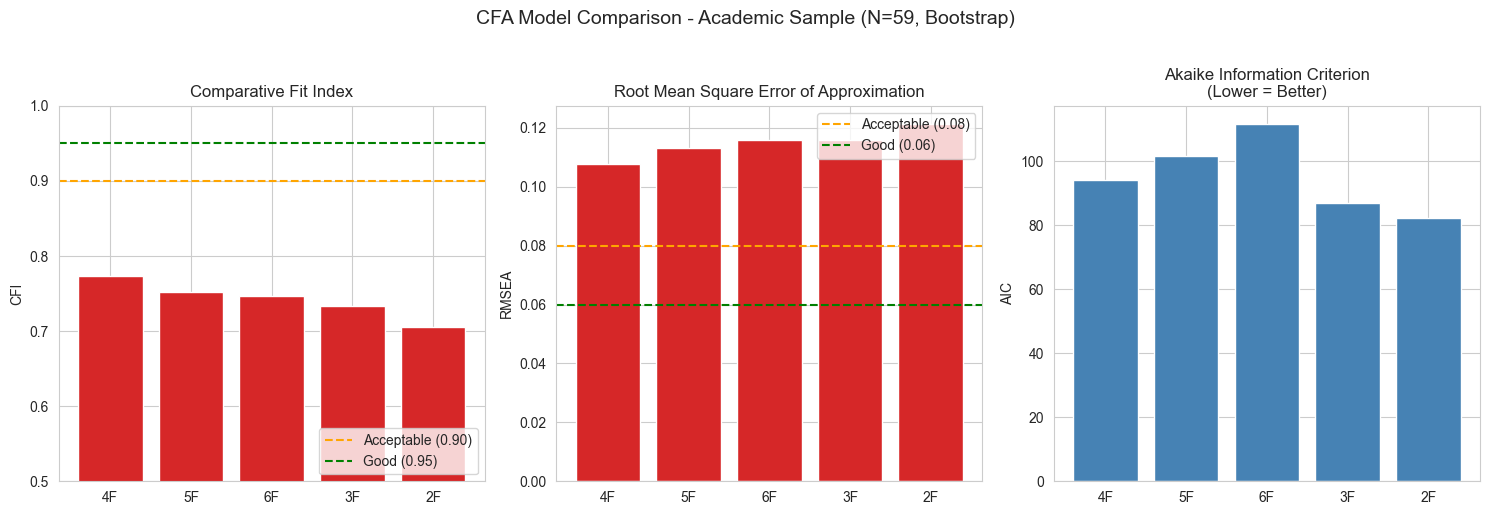

✓ Model comparison chart saved


In [42]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = [m['model'] for m in model_scores]
cfis = [m['CFI'] for m in model_scores]
rmseas = [m['RMSEA'] for m in model_scores]
aics = [m['AIC'] for m in model_scores]

# CFI
colors_cfi = ['#2ca02c' if c >= 0.95 else '#ff7f0e' if c >= 0.90 else '#d62728' for c in cfis]
axes[0].bar(models, cfis, color=colors_cfi)
axes[0].axhline(y=0.90, color='orange', linestyle='--', label='Acceptable (0.90)')
axes[0].axhline(y=0.95, color='green', linestyle='--', label='Good (0.95)')
axes[0].set_ylabel('CFI')
axes[0].set_title('Comparative Fit Index')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0.5, 1.0)

# RMSEA
colors_rmsea = ['#2ca02c' if r <= 0.06 else '#ff7f0e' if r <= 0.08 else '#d62728' for r in rmseas]
axes[1].bar(models, rmseas, color=colors_rmsea)
axes[1].axhline(y=0.08, color='orange', linestyle='--', label='Acceptable (0.08)')
axes[1].axhline(y=0.06, color='green', linestyle='--', label='Good (0.06)')
axes[1].set_ylabel('RMSEA')
axes[1].set_title('Root Mean Square Error of Approximation')
axes[1].legend(loc='upper right')

# AIC
axes[2].bar(models, aics, color='steelblue')
axes[2].set_ylabel('AIC')
axes[2].set_title('Akaike Information Criterion\n(Lower = Better)')

plt.suptitle(f'CFA Model Comparison - {POPULATION.title()} Sample (N={n_holdout}, Bootstrap)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/02_cfa_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Model comparison chart saved")

## 7. Best Model Details

In [43]:
# Best model loadings
print(f"Best Model Details: {best_model_key}")
print("=" * 70)

best_model = best_result['model']
params = best_model.inspect(std_est=True)

loadings_df = params[params['op'] == '~'].copy()

if 'Est. Std' in loadings_df.columns:
    loadings_df = loadings_df[['rval', 'lval', 'Est. Std', 'Std. Err', 'z-value', 'p-value']]
    loadings_df.columns = ['Factor', 'Item', 'Loading', 'SE', 'z', 'p']
else:
    loadings_df = loadings_df[['rval', 'lval', 'Estimate', 'Std. Err', 'z-value', 'p-value']]
    loadings_df.columns = ['Factor', 'Item', 'Loading', 'SE', 'z', 'p']

loadings_df['Construct'] = loadings_df['Item'].apply(
    lambda x: metadata[x]['construct_abbr'] if x in metadata else 'Unknown'
)

def get_sig(p):
    if isinstance(p, str) or pd.isna(p):
        return '(fixed)'
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''

loadings_df['Sig'] = loadings_df['p'].apply(get_sig)

print(f"\nFactor Loadings (Standardized):")
display(loadings_df.round(4))

Best Model Details: 4F

Factor Loadings (Standardized):


,Factor,Item,Loading,SE,z,p,Construct,Sig
0,F1,PE1,0.6378,-,-,-,PE,(fixed)
1,F1,PE2,0.7837,0.265095,5.147767,0.0,PE,***
2,F1,HM2,0.7959,0.246326,5.209109,0.0,HM,***
3,F1,PV1,0.8189,0.263822,5.323397,0.0,PV,***
4,F1,PV2,0.8141,0.259061,5.299595,0.0,PV,***
5,F1,HB1,0.8043,0.257988,5.251064,0.0,HB,***
6,F1,HB2,0.7513,0.26546,4.980784,0.000001,HB,***
7,F1,VO1,0.7875,0.260517,5.166771,0.0,VO,***
8,F1,TR1,0.8109,0.235015,5.283658,0.0,TR,***
9,F1,TR2,0.7008,0.226766,4.711197,0.000002,TR,***


In [44]:
# Reliability
reliability_df = best_result['reliability']

print(f"\nReliability Assessment - {best_model_key}:")
print("=" * 70)
print("Thresholds: CR ≥ 0.70, AVE ≥ 0.50, Alpha ≥ 0.70")
display(reliability_df.round(4))


Reliability Assessment - 4F:
Thresholds: CR ≥ 0.70, AVE ≥ 0.50, Alpha ≥ 0.70


,Factor,N_Items,Cronbach_Alpha,CR,AVE,CR_Status,AVE_Status
0,F1,10,0.9361,0.9364,0.5968,✓,✓
1,F3,4,0.4894,0.5759,0.3273,⚠️,⚠️
2,F2,6,0.7746,0.7573,0.3657,✓,⚠️
3,F4,4,0.5541,0.5752,0.3478,⚠️,⚠️


## 8. Export Results

In [45]:
# Export results
comparison_df.to_csv('tables/02_cfa_model_comparison.csv', index=False)
loadings_df.to_csv('tables/02_cfa_loadings.csv', index=False)
reliability_df.to_csv('tables/02_cfa_reliability.csv', index=False)

cfa_export = {
    'population': POPULATION,
    'n_holdout': n_holdout,
    'small_sample': n_holdout < 100,
    'bootstrap_iterations': N_BOOTSTRAP,
    'models_tested': list(cfa_results.keys()),
    'best_model': best_model_key,
    'model_comparison': [
        {
            'model': r['model'],
            'CFI': r['CFI'],
            'RMSEA': r['RMSEA'],
            'AIC': r['AIC'],
            'acceptable': r['acceptable']
        }
        for r in model_scores
    ],
    'best_model_details': {
        'n_factors': best_result['n_factors'],
        'fit_indices': best_result['indices'],
        'bootstrap': boot_results,
        'items_per_factor': best_result['items_per_factor'],
        'reliability': reliability_df.to_dict('records')
    }
}

with open('data/cfa_results.json', 'w') as f:
    json.dump(cfa_export, f, indent=2, default=str)

print("✓ Results exported")

✓ Results exported


## 9. Summary

In [46]:
best_indices = best_result['indices']
best_assessment = best_result['assessment']

print("=" * 60)
print(f"CFA SUMMARY - {POPULATION.upper()} SAMPLE")
print("=" * 60)

print(f"\nSample: N = {n_holdout} (holdout) - SMALL SAMPLE")
print(f"Models tested: {len(cfa_results)} ({', '.join(cfa_results.keys())})")
print(f"Bootstrap iterations: {N_BOOTSTRAP}")

print(f"\nBest Model: {best_model_key}")
print(f"   CFI: {best_indices['CFI']:.4f} {best_assessment['CFI_status']}")
print(f"        Bootstrap 95% CI: [{boot_results['CFI_ci_lower']:.3f}, {boot_results['CFI_ci_upper']:.3f}]")
print(f"   TLI: {best_indices['TLI']:.4f} {best_assessment['TLI_status']}")
print(f"   RMSEA: {best_indices['RMSEA']:.4f} {best_assessment['RMSEA_status']}")
print(f"          Bootstrap 95% CI: [{boot_results['RMSEA_ci_lower']:.3f}, {boot_results['RMSEA_ci_upper']:.3f}]")

print(f"\nReliability:")
for _, row in reliability_df.iterrows():
    print(f"   {row['Factor']}: CR={row['CR']:.3f} {row['CR_Status']}, AVE={row['AVE']:.3f} {row['AVE_Status']}")

good_fit = best_indices['CFI'] >= 0.90 and best_indices['RMSEA'] <= 0.08
good_reliability = all(reliability_df['CR'] >= 0.70)
good_ave = all(reliability_df['AVE'] >= 0.50)

print(f"\nOverall Assessment:")
print(f"   Model Fit: {'⚠️ Interpret with caution (small N)' if not good_fit else '✓ Acceptable'}")
print(f"   Reliability: {'✓ Good' if good_reliability else '⚠️ Issues detected'}")
print(f"   Convergent Validity: {'✓ Good' if good_ave else '⚠️ Issues detected'}")

CFA SUMMARY - ACADEMIC SAMPLE

Sample: N = 59 (holdout) - SMALL SAMPLE
Models tested: 5 (2F, 3F, 4F, 5F, 6F)
Bootstrap iterations: 500

Best Model: 4F
   CFI: 0.7727 ❌ Poor
        Bootstrap 95% CI: [0.415, 0.649]
   TLI: 0.7450 ❌ Poor
   RMSEA: 0.1076 ❌ Poor
          Bootstrap 95% CI: [0.160, 0.233]

Reliability:
   F1: CR=0.936 ✓, AVE=0.597 ✓
   F3: CR=0.576 ⚠️, AVE=0.327 ⚠️
   F2: CR=0.757 ✓, AVE=0.366 ⚠️
   F4: CR=0.575 ⚠️, AVE=0.348 ⚠️

Overall Assessment:
   Model Fit: ⚠️ Interpret with caution (small N)
   Reliability: ⚠️ Issues detected
   Convergent Validity: ⚠️ Issues detected
